# Computer Vision

## Get to Know Data

In [ ]:
# computer vision libraries
# - torchvision


In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

torch.__version__, torchvision.__version__


('2.1.0+cu118', '0.16.0+cu118')

In [ ]:
# get FashionMNIST dataset

from torchvision import datasets

train_data = datasets.FashionMNIST(
    root="data", # where to download
    train=True, # train data
    download=True,
    transform=ToTensor(), # convert to tensor
    target_transform=None #transorm labels
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# an example
image, label = train_data[0]

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
image.shape, label

(torch.Size([1, 28, 28]), 9)

Text(0.5, 1.0, '9')

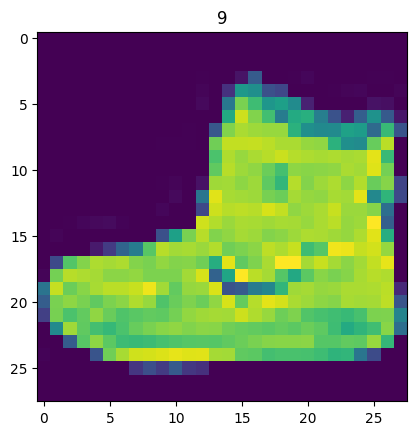

In [ ]:
plt.imshow(image.squeeze())
plt.title(label)

(-0.5, 27.5, 27.5, -0.5)

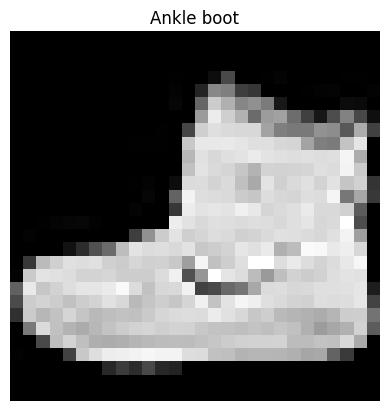

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

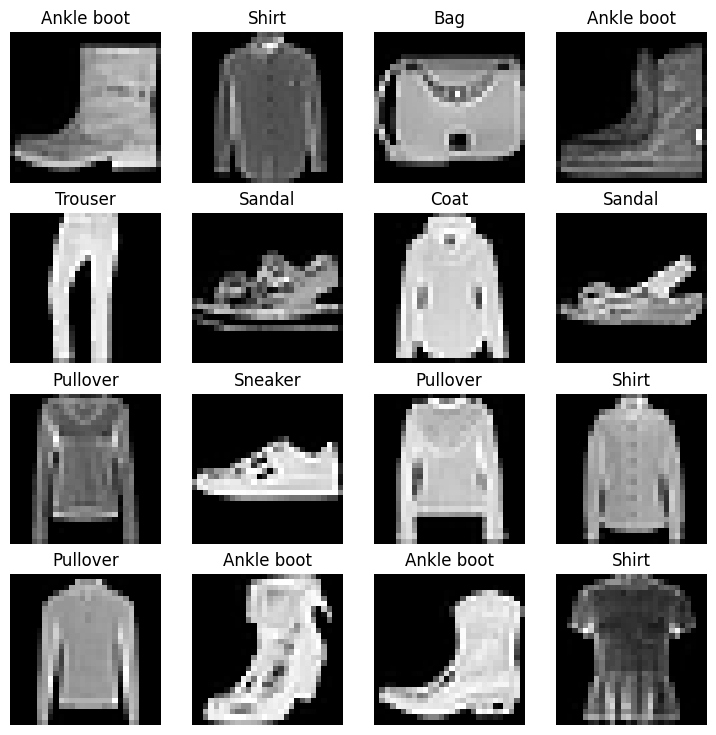

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)


## Prepare `DataLoader`

In [ ]:
# prepare DataLoader
# the dtype rn is Pytorch Dataset
# DataLoader makes it iterable = batches

from torch.utils.data import DataLoader

BATCH_SIZE = 32

#turn dataset into iterables(batch)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79f413c62320>,
 <torch.utils.data.dataloader.DataLoader at 0x79f413c62c20>)

In [ ]:
# check inside dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


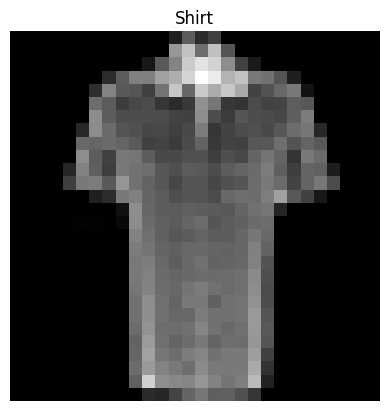

In [ ]:
# show a samples
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## Build Model

In [ ]:
# BUILD MODEL

#create a flatten layer
flatten_model = nn.Flatten()

x = train_features_batch[0]


# flatten the sample
output = flatten_model(x)

In [ ]:
x.shape

torch.Size([1, 28, 28])

In [ ]:
output.shape

torch.Size([1, 784])

In [ ]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784, # 28 * 28
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

In [ ]:
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
# set loss optim and eval
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("skip")
else:
  print("downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

skip


## Train

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# time measuring functi0n
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
start_time = timer()
end_time = timer()

print_train_time(start_time, end_time, "cpu")

Train time on cpu: 0.000 seconds


4.417399986778037e-05

In [ ]:
# create loop and train in batches instead of epoch

from tqdm.auto import tqdm # for progress bar

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")

  train_loss = 0

  # add a loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss # acc train loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X) / len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)

  #test
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.4f} | Test loss:{test_loss:.4f} | Test acc: {test_acc:.4f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0.0 samples
Looked at 0.21333333333333335 samples
Looked at 0.4266666666666667 samples
Looked at 0.64 samples
Looked at 0.8533333333333334 samples

Train loss: 0.5904 | Test loss:0.5095 | Test acc: 82.0387
Epoch: 1
-----
Looked at 0.0 samples
Looked at 0.21333333333333335 samples
Looked at 0.4266666666666667 samples
Looked at 0.64 samples
Looked at 0.8533333333333334 samples

Train loss: 0.4763 | Test loss:0.4799 | Test acc: 83.1969
Epoch: 2
-----
Looked at 0.0 samples
Looked at 0.21333333333333335 samples
Looked at 0.4266666666666667 samples
Looked at 0.64 samples
Looked at 0.8533333333333334 samples

Train loss: 0.4550 | Test loss:0.4766 | Test acc: 83.4265
Train time on cpu: 35.809 seconds


## Evaluate

In [ ]:
# evaluate
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

model_0_results = eval_model(model_0,
                             test_dataloader,
                             loss_fn,
                             accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Pipeline with Device Agnostic Code

In [ ]:
!nvidia-smi

Fri Nov 24 20:11:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [ ]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}\n")



In [ ]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y,
                              y_pred=y_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}\n")


In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}-----")
  train_step(model_1,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn,
             device)
  test_step(model_1,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device
            )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0-----
Train loss: 1.09199 | Train acc: 61.34

Test loss: 0.95636 | Test acc: 65.00

Epoch 1-----
Train loss: 0.78101 | Train acc: 71.93

Test loss: 0.72227 | Test acc: 73.91

Epoch 2-----
Train loss: 0.67027 | Train acc: 75.94

Test loss: 0.68500 | Test acc: 75.02

Train time on cuda: 30.933 seconds


In [ ]:
# evaluate
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
               device="cpu"):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}


In [ ]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

## Convolutional Neural Networks

In [ ]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=490, #*0, #trick
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shape=1, # black-white 1 color channel
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

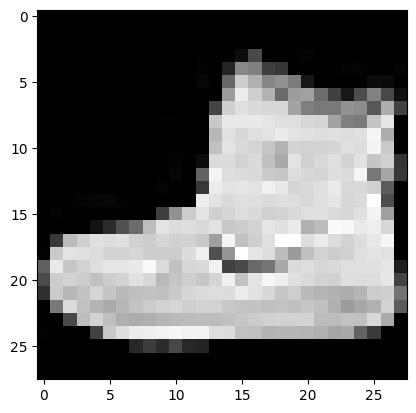

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")

In [ ]:
model_2(image.unsqueeze(0).to(device))

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# inside a conv2d

torch.manual_seed(42)
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]
images.shape, test_image.shape, test_image

(torch.Size([32, 3, 64, 64]),
 torch.Size([3, 64, 64]),
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
          [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
          [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
          ...,
          [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
          [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
          [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],
 
         [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
          [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
          [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
          ...,
          [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
          [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
          [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],
 
         [[-0.7978,  1.0261,  1.1465,  ..., 

In [ ]:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

In [ ]:
# maxpool layer
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)
test_image_through_conv = conv_layer(test_image)
print(test_image_through_conv.shape)

test_image_through_conv_maxpool = max_pool_layer(test_image_through_conv)
print(test_image_through_conv_maxpool.shape)

torch.Size([10, 62, 62])
torch.Size([10, 31, 31])


In [ ]:
# train cnn
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}-----\n")
  train_step(model_2,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn,
             device)
  test_step(model_2,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(train_time_start_model_2, train_time_end_model_2, device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0-----

Train loss: 0.59421 | Train acc: 78.50

Test loss: 0.41099 | Test acc: 85.08

Epoch: 1-----

Train loss: 0.36264 | Train acc: 86.92

Test loss: 0.35501 | Test acc: 87.03

Epoch: 2-----

Train loss: 0.32620 | Train acc: 88.23

Test loss: 0.32692 | Test acc: 88.22

Train time on cuda: 37.196 seconds


In [ ]:
model_2_results = eval_model(model_2,
                             test_dataloader,
                             loss_fn,
                             accuracy_fn,
                             device)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3269158899784088,
 'model_acc': 88.21884984025559}

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.326916,88.218850


In [ ]:
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,35.809257
1,FashionMNISTModelV1,0.685001,75.019968,30.932942
2,FashionMNISTModelV2,0.326916,88.218850,37.196053


Text(0, 0.5, 'model')

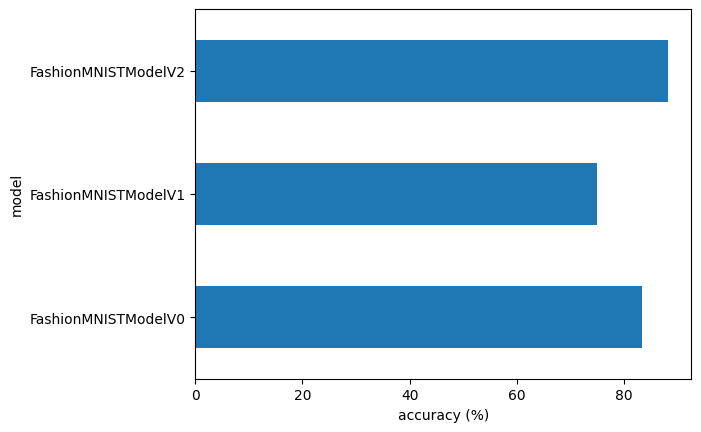

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [ ]:
# eval rand pics
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  model.to(device)
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

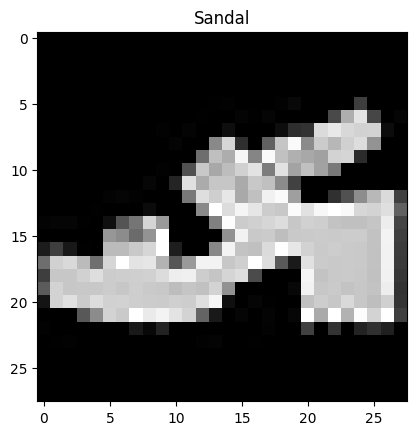

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
pred_probs = make_predictions(model=model_2,
                              data=test_samples,
                              device=device)

pred_probs[:2]

tensor([[8.8461e-08, 5.2917e-09, 5.5415e-08, 1.3909e-08, 8.2996e-09, 9.9987e-01,
         1.3653e-07, 1.3110e-05, 3.3136e-05, 8.6925e-05],
        [2.1424e-02, 8.0241e-01, 5.3914e-04, 9.1844e-02, 3.8740e-02, 2.2117e-05,
         4.4663e-02, 2.3412e-04, 4.9324e-05, 7.3794e-05]])

In [ ]:
pred_classes = pred_probs.argmax(dim=1)

In [ ]:
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

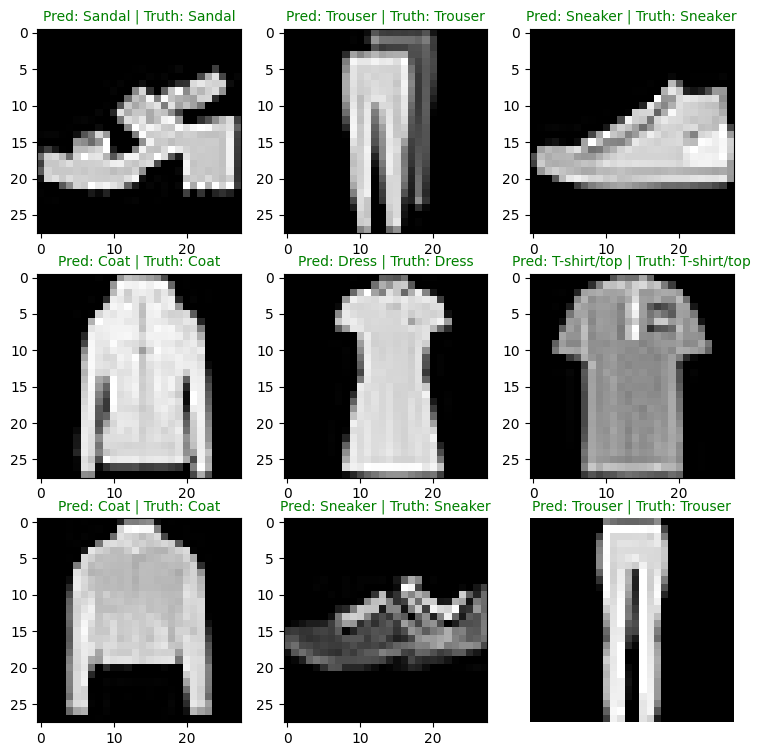

In [ ]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

plt.axis(False);

In [ ]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making preds"):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making preds:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 2])

## Confusion Matrix

In [ ]:
try:
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1] >= 19), "0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.4 MB/s eta 0:00:00


In [ ]:

mlxtend.__version__

'0.22.0'

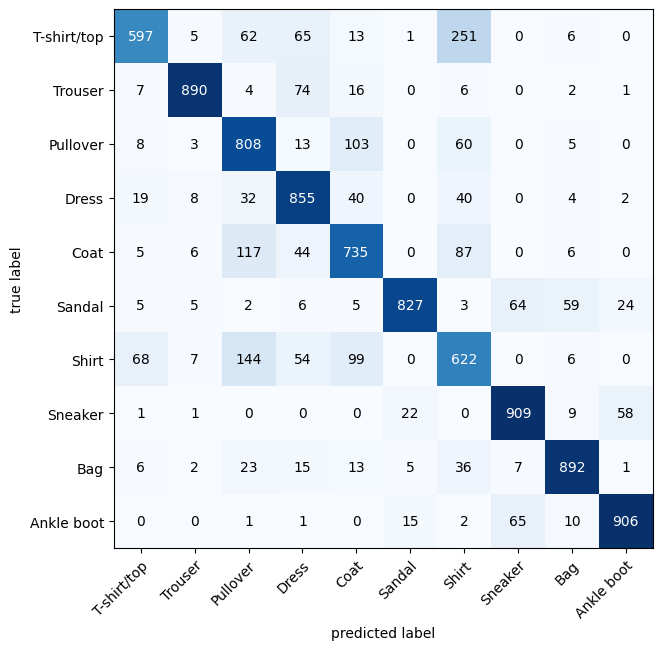

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

In [ ]:
confmat_tensor

tensor([[597,   5,  62,  65,  13,   1, 251,   0,   6,   0],
        [  7, 890,   4,  74,  16,   0,   6,   0,   2,   1],
        [  8,   3, 808,  13, 103,   0,  60,   0,   5,   0],
        [ 19,   8,  32, 855,  40,   0,  40,   0,   4,   2],
        [  5,   6, 117,  44, 735,   0,  87,   0,   6,   0],
        [  5,   5,   2,   6,   5, 827,   3,  64,  59,  24],
        [ 68,   7, 144,  54,  99,   0, 622,   0,   6,   0],
        [  1,   1,   0,   0,   0,  22,   0, 909,   9,  58],
        [  6,   2,  23,  15,  13,   5,  36,   7, 892,   1],
        [  0,   0,   1,   1,   0,  15,   2,  65,  10, 906]])

In [ ]:
# save & load
from pathlib import Path

MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "best_com_vision.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)